<a href="https://colab.research.google.com/github/cnarte/Machine_learning/blob/master/Copy_of_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A FEW THINGS TO KNOW BEFORE STARTING:
PLEASE SWITCH YOUR RUNTIME TYPE TO GPU FROM YOUR LOCAL MACHINE.

Hello Attendees!
If you are here, we have reached the end of our journey.
Its time to give you your Project to be. The best part!
We have almost made it for you so that you dont have to code most of it.
Your role as a learner would be to gain the most out of this notebook and try solving some of the code that we left for you to work on.
To make searching for the codes easier you can use the documentation and guide by tensorflow.

https://www.tensorflow.org/guide

https://www.tensorflow.org/tutorials

We will be explaining you all the codes written below and how to reach your final destination, i.e. a working twitter sentiment analysis project.

To make it interesting for all of you, we promote experimentation on the existing code after the implementation of the said tasks. These can be a foundational notebook to build something better.

This can be considered a template for YOUR code. So, we provide you with the full creative freedom to edit the dataset, use different models, change what predictions you want and the preprocessing. 

Your final task would be to write a small brief about what you did and make a simple report.

This is your project, Its your empty canvas.
 
We look forward to seeing you all with your ideas!

In addition to this try deploying your model with the help of the example in the link provided below.
https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

So, what are you waiting for?
lets get this notebook working.



As usual we will start our project by importing the needed libraries. This step is already completed for you so that you only focus on the major parts.

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import gc
import pprint
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In the next step we have downloaded the needed stopwords so that they can be omitted while training the model.

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. ... Such words are already captured this in corpus named corpus.

In simpler words, stopwords are words that dont bring you too much information when it comes to their value in a sentence.

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will now be uploading the csv files related to this notebook which is provided with this

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will now be defining some needed parameters that we will be using frequently in the code to remove any confusion and have a smooth operation. We will be using them in the code so do refer them incase you get stuck somewhere.

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 20
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

Here we create a pandas dataframe and save our csv file for further operations using pd.read_csv().

In [6]:
import io 
  
df = pd.read_csv('/content/drive/My Drive/DEEPINFO CAPSTONE/Copy of training.1600000.processed.noemoticon.csv',encoding =DATASET_ENCODING,names=DATASET_COLUMNS)


We now see the number of entries we have stored in our dataset. From now on your role will be significant. So, lets get started!

In [7]:
print("Dataset size:", len(df))

Dataset size: 1600000


 Task 1:Display the first Five values

View the first five values of the dataset. 

In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


After successfully viewing the starting entries, we now generate a decode map to segregate the tweets into three categories namely NEGATIVE NEUTRAL and POSITIVE.

In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
    

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 446 ms, sys: 0 ns, total: 446 ms
Wall time: 449 ms


In [11]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

Task 2: Plot a bar chart of target variables

Now you need to generate a bar chart of target variables using plt.figure(),plt.bar() etc. 

In [12]:
target_cnt = Counter(df.target)
print(target_cnt)

Counter({'NEGATIVE': 800000, 'POSITIVE': 800000})


In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

Removal of special characters links and users will happen here with the following code using split text ,.append() and .join



In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 39.6 s, sys: 134 ms, total: 39.7 s
Wall time: 39.7 s


Task 3 Train Test split

Your task will include splitting the train and test data in such a way that the test size is 0.8 with the random_state being 42. Print the sizes for the training subset and the test subset after successful implementation.



In [16]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.8, random_state=42)

In [17]:
X_train.shape

(320000, 6)

In [18]:
X_test.shape

(1280000, 6)

In [19]:
%%time
documents = [_text.split() for _text in X_train.text] 

CPU times: user 732 ms, sys: 61.9 ms, total: 793 ms
Wall time: 796 ms


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec()

In [21]:
w2v_model.build_vocab(documents)

2020-10-10 19:08:04,960 : INFO : collecting all words and their counts
2020-10-10 19:08:04,961 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-10 19:08:04,986 : INFO : PROGRESS: at sentence #10000, processed 72275 words, keeping 13888 word types
2020-10-10 19:08:05,002 : INFO : PROGRESS: at sentence #20000, processed 143685 words, keeping 21444 word types
2020-10-10 19:08:05,023 : INFO : PROGRESS: at sentence #30000, processed 215629 words, keeping 27508 word types
2020-10-10 19:08:05,045 : INFO : PROGRESS: at sentence #40000, processed 287040 words, keeping 32777 word types
2020-10-10 19:08:05,063 : INFO : PROGRESS: at sentence #50000, processed 358550 words, keeping 37585 word types
2020-10-10 19:08:05,084 : INFO : PROGRESS: at sentence #60000, processed 430582 words, keeping 42067 word types
2020-10-10 19:08:05,109 : INFO : PROGRESS: at sentence #70000, processed 502201 words, keeping 46182 word types
2020-10-10 19:08:05,128 : INFO : PROGRESS: at s

After building vocabulary on the given tweets in the dataset we now see the size of our created vocabulary that will be helping us to judge to sentiment behind the tweet.

In [22]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 21295


In [23]:
print(len(documents))

320000


Task 4: We will now train the w2v model using w2v_model.train()
with parameters as documents,total_examples=len(documents), epochs= look for the epochs in the parameters stored in the starting.

In [24]:
%%time
w2v_model.train(sentences=documents , total_examples=len(documents),epochs=20)

2020-10-10 19:08:09,564 : INFO : training model with 3 workers on 21295 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-10-10 19:08:10,592 : INFO : EPOCH 1 - PROGRESS: at 30.87% examples, 616888 words/s, in_qsize 5, out_qsize 0
2020-10-10 19:08:11,610 : INFO : EPOCH 1 - PROGRESS: at 62.08% examples, 619253 words/s, in_qsize 6, out_qsize 0
2020-10-10 19:08:12,639 : INFO : EPOCH 1 - PROGRESS: at 93.77% examples, 620590 words/s, in_qsize 4, out_qsize 1
2020-10-10 19:08:12,803 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-10 19:08:12,805 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-10 19:08:12,816 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-10 19:08:12,817 : INFO : EPOCH - 1 : training on 2302487 raw words (2024652 effective words) took 3.2s, 625496 effective words/s
2020-10-10 19:08:13,843 : INFO : EPOCH 2 - PROGRESS: at 30.45% examples, 604000 words/s, in_qsize 5, 

CPU times: user 2min 4s, sys: 552 ms, total: 2min 4s
Wall time: 1min 6s


(40494318, 46049740)

To test our vocabulary bank we will now test our bank by asking it to give results that are most similar to the word "love". Feel free to test it for different words to understand the workings related to this.

In [25]:
w2v_model.most_similar("love")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

2020-10-10 19:09:15,713 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('luv', 0.6266830563545227),
 ('loves', 0.5968639850616455),
 ('adore', 0.569861888885498),
 ('looove', 0.5325645804405212),
 ('loved', 0.5317150354385376),
 ('loove', 0.5145713686943054),
 ('looooove', 0.5078535676002502),
 ('loveeee', 0.4965161383152008),
 ('loveee', 0.45919129252433777),
 ('duet', 0.4560692310333252)]

Task 5: Tokenizer Initialization

We will now initialize a token by using Tokenizer() and .fit_on_texts




In [26]:
%%time
tk = Tokenizer()
tk.fit_on_texts(documents)
vocab_size = len(tk.word_index) + 1
print("Total words", vocab_size)

Total words 119827
CPU times: user 2.09 s, sys: 104 ms, total: 2.19 s
Wall time: 2.1 s


In [27]:
%%time
x_train = pad_sequences(tk.texts_to_sequences(X_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tk.texts_to_sequences(X_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 22.9 s, sys: 482 ms, total: 23.3 s
Wall time: 23.4 s


 Task 6: Append NEUTRAL to target list
 name it as "labels" or store it in labels

 you can use df_train.target.unique().tolist() 
 and then use append()

In [29]:
labels = X_train.target.unique().tolist()
labels.append('NEUTRAL')
print(labels)

['NEGATIVE', 'POSITIVE', 'NEUTRAL']


Here we create an encoder and then fit it along with using transform() on y_train and y_test. This will be continued by reshaping y_train and y_test.

In [30]:
encoder = LabelEncoder()
encoder.fit(X_train.target.tolist())

y_train = encoder.transform(X_train.target.tolist())
y_test = encoder.transform(X_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (320000, 1)
y_test (1280000, 1)


Task 7: Print shapes of x_train, x_test, y_test , y_train.

In [31]:
print(x_train.shape,"\n", x_test.shape,"\n" ,y_test.shape ,"\n" ,y_train.shape)


(320000, 300) 
 (1280000, 300) 
 (1280000, 1) 
 (320000, 1)


In [32]:
y_train[:10]


array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tk.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(119827, 100)


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


Task 8: Store Sequential() in model 
and add an embedding layer, a dropout =0.5, use LTSM with the followinig parameters (100, dropout=0.2 and recuurent dropout to be 0.2 as well).

add a dense layer with parameters (1 and an activation function to be "sigmoid")

print the model summary as well

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

2020-10-10 19:10:13,072 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Task 9: Compile the created model with binary crossentropy alongside adam as an optimizer with accuracy as metrics.

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model)

In [37]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Task 10: Fit the model as 'history' with the needed parameters:
x_train, y_train,

batch_size=BATCH_SIZE,

epochs=EPOCHS,

validation_split=0.1,

verbose=1,

callbacks=callbacks

NOTE: feel free to change the batch size and epochs to optimize your model and bringing about changes that you feel will help.


In [38]:
%%time
history = model.fit(x=x_train,y=y_train,batch_size= BATCH_SIZE,epochs= EPOCHS,validation_split=0.1,verbose=1,callbacks=callbacks)

282/282 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.7416WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-10-10 19:15:02,818 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


282/282 [==============================] - 285s 1s/step - loss: 0.5171 - accuracy: 0.7416 - val_loss: 0.4832 - val_accuracy: 0.7666
CPU times: user 6min 50s, sys: 1min 2s, total: 7min 53s
Wall time: 4min 49s


In [39]:
print(history.history['loss'])

[0.5171446800231934]


Task 11:Evaluate the needed model and print out the accuracy and loss.

In [40]:
%%time
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 76.57%
CPU times: user 45min 38s, sys: 1min 23s, total: 47min 1s
Wall time: 44min 16s


Task 12: You now need to plot accuracy,validation_accuracy, loss and validation_loss graphs to see the trend in which your model learned

In [41]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(accuracy))
 
##

In [42]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [43]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tk.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

Task 13: You need to create an example like the ones below to test it on that.

In [44]:
predict("loved it")

{'elapsed_time': 0.3055260181427002,
 'label': 'POSITIVE',
 'score': 0.7817886471748352}

In [45]:
predict("I hate the rain")

{'elapsed_time': 0.09422683715820312,
 'label': 'NEGATIVE',
 'score': 0.02518615312874317}

In [46]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.09103536605834961,
 'label': 'NEUTRAL',
 'score': 0.5690711736679077}

In [47]:
%%time
y_pred_1d = []
y_test_1d = list(X_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

160/160 [==============================] - 129s 804ms/step
CPU times: user 1min 29s, sys: 44.8 s, total: 2min 13s
Wall time: 2min 11s


Task 14 : You need to plot the confusion matrix. Snippets of the code will be provided, you need to fill in the required blanks to make it a genuine code

In [48]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(rotation = -45)
    plt.yticks(tick_marks, classes, fontsize=22)
    fmt= ".2f"
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

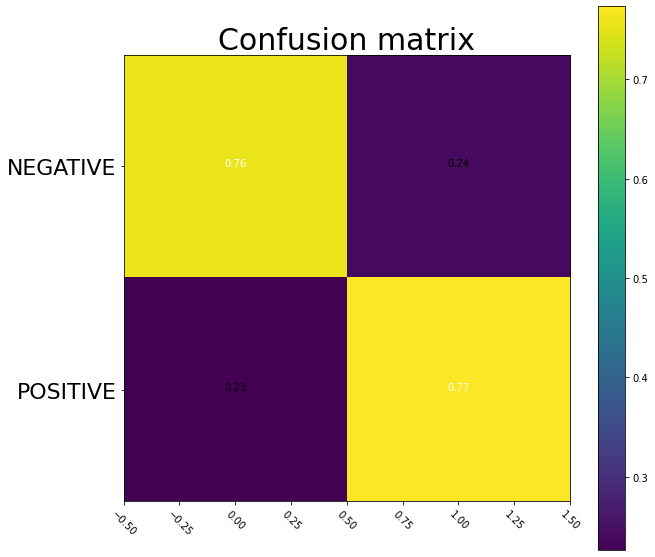

CPU times: user 3.36 s, sys: 115 ms, total: 3.48 s
Wall time: 3.49 s


In [49]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=X_train.target.unique(), title="Confusion matrix")
plt.show()

In [50]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.76      0.76    640104
    POSITIVE       0.76      0.77      0.77    639896

    accuracy                           0.77   1280000
   macro avg       0.77      0.77      0.77   1280000
weighted avg       0.77      0.77      0.77   1280000



In [51]:
accuracyscore = accuracy_score( y_true= y_test_1d, y_pred= y_pred_1d)

Task 15: Print out accuracy score for the classification.

In [52]:
print(accuracyscore)

0.76565859375


Task 16: Save your model and w2v_model and dump tokenizer and encoder.

In [60]:
with open('nlp-ank.pickle', 'wb') as handle:
    pickle.dump([tk,model], handle, protocol=pickle.HIGHEST_PROTOCOL)
    

TypeError: ignored

In [ ]:
p

In [ ]:
gc.collect()